In [2]:
# Initial imports

# ignore metric did not predict warning
import warnings
warnings.filterwarnings("ignore")
from IPython.display import display, HTML

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statistics import mean, mode
from pathlib import Path
from imblearn.pipeline import Pipeline
# from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, StratifiedKFold, GridSearchCV, cross_val_score, cross_validate, validation_curve
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE  
from binary_classifier import model_compare

In [3]:
# Loading data
file_path = Path("../eda/reduced_filtered_df.csv")
df = pd.read_csv(file_path)
df.head(1)

,ACD,LT,VCD,SPORTHR,DADMY,delta_spheq,total_positive_screen,MYOPIC
0,3.702,3.392,15.29,4,1,1.358,8,0


In [4]:
# Check dataset balance
df["MYOPIC"].value_counts()

0    323
1     49
Name: MYOPIC, dtype: int64

In [5]:
# Define X,y
label = df["MYOPIC"]
X = df.iloc[:,:-1].copy()

In [6]:
# Holdback Method with stratify as True
X_train, X_test, y_train, y_test = train_test_split(X, label, test_size=200, random_state=42, stratify=label)

In [7]:
len(y_test)

200

In [8]:
# Settings for all models

# dictionary that will become a pandas dataframe
# summary=[]

# target labels
labels=['not_myopic', 'myopic']

# 5 fold cross validation
cv = StratifiedKFold(n_splits=5)

## SVC Unbalanced Data
- linear kernel

In [9]:
# create process steps
pipes = [
    ("scaler", StandardScaler()),
    ("svc", SVC(random_state=2, probability=True))
]

summary_dict = model_compare('SVC Unbalanced Data', X_train, y_train, X_test, y_test, labels, pipes, cv);

,scenario,type,pipe1,pipe2,pipe3,pipe4,pipe5,cv,f1-score,recall,precision,ROC_AUC,Precision_Recall_AUC,accuracy
0,SVC Unbalanced Data,cross_validation,StandardScaler(),"SVC(probability=True, random_state=2)",,,,"StratifiedKFold(n_splits=5, random_state=None,...",0.133333,0.09,0.3,0.754057,0.43,0.866555


- Baseline model that has no preprocessing - the results show that it has very low precision and recall scores.  Although I calculate the ROC AUC, I am going to give the Precision Recall AUC more merit since this dataset is imbalanced.

## SVC Unbalanced Data GridsearchCV

In [10]:
# create process steps
pipes = [
    ("scaler", StandardScaler()),
    ("svc", SVC(random_state=2, probability=True))
]

# set gridsearch parameters
params = {
    "svc__C": [0.0001, 0.001, 0.01, 0.1, 1, 5, 10, 50, 100, 1000]
}

summary_dict = model_compare('SVC Unbalanced Data GridsearchCV', X_train, y_train, X_test, y_test, labels, pipes, cv, tuner_params=params)

,scenario,type,pipe1,pipe2,pipe3,pipe4,pipe5,cv,f1-score,recall,precision,ROC_AUC,Precision_Recall_AUC,accuracy,tuning_params
0,SVC Unbalanced Data GridsearchCV,cross_validation,StandardScaler(),"SVC(C=1, probability=True, random_state=2)",,,,"StratifiedKFold(n_splits=5, random_state=None,...",0.133333,0.09,0.3,0.754057,0.43,0.866555,NaN


- This model adds some parameter hypertuning to the model but operates no differently than the baseline because the value of C is 1 and that was the default value in first model.

In [18]:
# # print params
# param_list = [f"{k}={v}" for k,v in grid.best_params_.items()]
# exec(param_list[0])

## SVC Unbalanced Data PCA GridsearchCV

In [11]:
# create process steps
pipes = [
    ("scaler", StandardScaler()),
    ("pca", PCA(random_state=1)),
    ("svc", SVC(random_state=2, probability=True))
]

# set gridsearch parameters
params = {
    "svc__C": [0.0001, 0.001, 0.01, 0.1, 1, 5, 10, 50, 100, 1000],
    "pca__n_components":[4,5,6,7]
}

summary_dict = model_compare('SVC Unbalanced Data PCA GridsearchCV', X_train, y_train, X_test, y_test, labels, pipes, cv, tuner_params=params)

,scenario,type,pipe1,pipe2,pipe3,pipe4,pipe5,cv,f1-score,recall,precision,ROC_AUC,Precision_Recall_AUC,accuracy,tuning_params
0,SVC Unbalanced Data PCA GridsearchCV,cross_validation,StandardScaler(),"PCA(n_components=7, random_state=1)","SVC(C=1, probability=True, random_state=2)",,,"StratifiedKFold(n_splits=5, random_state=None,...",0.133333,0.09,0.3,0.754057,0.43,0.866555,NaN


- This model uses PCA and GridSearch and there is more than a doubling of the scores.  The ROC AUC score actually came down but the Precision Recall AUC went up.  The precision score is 0.45 which is what I was expecting since that is similar to other models I have run.  

## SVC Balanced Data

In [12]:
# create process steps
pipes = [
    ("over", SMOTE(random_state=1)),
    ("scaler", StandardScaler()),
    ("svc", SVC(random_state=2, probability=True))
]

summary_dict = model_compare('SVC Balanced Data', X_train, y_train, X_test, y_test, labels, pipes, cv)

,scenario,type,pipe1,pipe2,pipe3,pipe4,pipe5,cv,f1-score,recall,precision,ROC_AUC,Precision_Recall_AUC,accuracy
0,SVC Balanced Data,cross_validation,SMOTE(random_state=1),StandardScaler(),"SVC(probability=True, random_state=2)",,,"StratifiedKFold(n_splits=5, random_state=None,...",0.359762,0.47,0.335101,0.795632,0.37,0.785042


- From previous experiments, I found SMOTE to be a good balancer for this dataset.  There were several other very similar balancers that would have worked fine for this data.

- Interesting that my f1-score increased significantly but that is due to my recall score being much better and my precisin score reducing a less substantial amount.  I'm not sure how much I would trust this model since the Precision Recall AUC went down considerably.  

- This model seems to have shifted some of the classifications around the threshold.  From first guess, I would say that since we increased the dataset size synthetically, the samples created would have been y value targets and if these values are in an uncertain area of the dimensional space then it is using the ratio of target classes to assign classifications - our new class ration is 1:1 so it is randomly assigning.  Before it was 1:8 so it was guessing much more often that it was the majority class (0 aka not-myopic).  This would explain why precision went down - more false positives were predicted since it was a 50% probability now verus a 12% probability before.  The recall went up for similar reasons - the number of TP went up but the number of false negatives stayed the same or went down (before 87% of uncertains were predicted false so with balancing only 50% are predicted false.)  

## SVC Balanced Data PCA GridsearchCV

In [13]:
# create process steps
pipes = [
    ("over", SMOTE(random_state=1)),
    ("scaler", StandardScaler()),
    ("pca", PCA(random_state=1)),
    ("svc", SVC(random_state=2, probability=True))
]

# set gridsearch parameters
params = {
    "svc__C": [0.0001, 0.001, 0.01, 0.1, 1, 5, 10, 50, 100, 1000],
    "pca__n_components":[4,5,6,7]
}

summary_dict = model_compare('SVC Balanced Data PCA GridsearchCV', X_train, y_train, X_test, y_test, labels, pipes, cv, tuner_params=params)

,scenario,type,pipe1,pipe2,pipe3,pipe4,pipe5,cv,f1-score,recall,precision,ROC_AUC,Precision_Recall_AUC,accuracy,tuning_params
0,SVC Balanced Data PCA GridsearchCV,cross_validation,SMOTE(random_state=1),StandardScaler(),"PCA(n_components=7, random_state=1)","SVC(C=100, probability=True, random_state=2)",,"StratifiedKFold(n_splits=5, random_state=None,...",0.397691,0.46,0.390794,0.796644,0.34,0.825042,NaN


- So this model is the same as before but with Gridsearch included.

- This model shows slight improvements with the f1-score going up slightly but maybe not significantly.  The precision did exeed 0.40 and is approaching the value from the unbalanced PCA Gridsearch model.  

## SVC Balanced Data Weighted GridsearchCV

In [14]:
# create process steps
pipes = [
    ("over", SMOTE(random_state=1)),
    ("scaler", StandardScaler()),
    ("svc", SVC(random_state=2, class_weight='balanced', probability=True))
]

# set gridsearch parameters
params = {
    "svc__C": [0.0001, 0.001, 0.01, 0.1, 1, 5, 10, 50, 100, 1000],
}

summary_dict = model_compare('SVC Balanced Data PCA GridsearchCV', X_train, y_train, X_test, y_test, labels, pipes, cv, tuner_params=params)

,scenario,type,pipe1,pipe2,pipe3,pipe4,pipe5,cv,f1-score,recall,precision,ROC_AUC,Precision_Recall_AUC,accuracy,tuning_params
0,SVC Balanced Data PCA GridsearchCV,cross_validation,SMOTE(random_state=1),StandardScaler(),"SVC(C=100, class_weight='balanced', probabilit...",,,"StratifiedKFold(n_splits=5, random_state=None,...",0.397691,0.46,0.390794,0.796644,0.34,0.825042,NaN


- The combination of this pipeline did not improve anything.  I'm not sure if using the oversampling and weight balancing makes any sense.  This was just one of those cases of checking to see what happends if I do this.  

## SVC Balanced Data PCA Weighted GridsearchCV 

In [23]:
# create process steps
pipes = [
    ("over", SMOTE(random_state=1)),
    ("scaler", StandardScaler()),
    ("pca", PCA(random_state=1)),
    ("svc", SVC(random_state=2, class_weight='balanced', probability=True))
]

# set gridsearch parameters
params = {
    "svc__C": [0.0001, 0.001, 0.01, 0.1, 1, 5, 10, 50, 100, 1000],
    "pca__n_components":[4,5,6,7]
}

summary_dict = model_compare('SVC Balanced Data PCA Weighted GridsearchCV ', X_train, y_train, X_test, y_test, labels, pipes, cv, tuner_params=params)

,scenario,type,pipe1,pipe2,pipe3,pipe4,pipe5,cv,f1-score,recall,precision,ROC_AUC,Precision_Recall_AUC,accuracy,tuning_params
0,SVC Balanced Data PCA Weighted GridsearchCV,cross_validation,SMOTE(random_state=1),StandardScaler(),"PCA(n_components=5, random_state=1)","SVC(C=1000, class_weight='balanced', probabili...",,"StratifiedKFold(n_splits=5, random_state=None,...",0.456457,0.560714,0.412383,0.786762,0.37,0.828052,NaN


- Same as before but added PCA 

- This model performed like its highly related relative from a couple steps above - the model that used balanced data, PCA, and oversampling.  This model performed almost exactly the same.  The SVC weight balancing parameter seemed to have no effect.  

## Unbalanced SVC with Class Weights

In [15]:
# create process steps
pipes = [
    ("scaler", StandardScaler()),
    ("pca", PCA(random_state=1)),
    ("svc", SVC(random_state=2, class_weight='balanced', probability=True))
]

# set gridsearch parameters
params = {
    "svc__C": [0.0001, 0.001, 0.01, 0.1, 1, 5, 10, 50, 100, 1000]
}

summary_dict = model_compare('Unbalanced SVC with Class Weights', X_train, y_train, X_test, y_test, labels, pipes, cv, tuner_params=params)

,scenario,type,pipe1,pipe2,pipe3,pipe4,pipe5,cv,f1-score,recall,precision,ROC_AUC,Precision_Recall_AUC,accuracy,tuning_params
0,Unbalanced SVC with Class Weights,cross_validation,StandardScaler(),PCA(random_state=1),"SVC(C=0.1, class_weight='balanced', probabilit...",,,"StratifiedKFold(n_splits=5, random_state=None,...",0.532778,0.81,0.409174,0.856862,0.41,0.802689,NaN


 - Since the SVC weight balancing did not have any effect in the previous model, I have used it here, without PCA and oversampling to see what effect it has.  

 - Recall and Precision both hover around 0.40 so neither really performed very well.  

## Summary

- f1-score best - 0.456 using balanced data with gridsearch and PCA (with or without weights)
- precision best - 0.44 using unbalanced data with gridsearch and PCA
- recall best -  0.58 using balanced data and 0.56 using balanced data with gridsearch and PCA (with or without weights)

- So the important take away is when comparing the models the oversampling effect will effect how the model is interpreted greatly since it will potentially increase recall and decrease precision.  

- the parameters for tuning may also not be great for this small dataset and may be overfitting in the training.  This will be checked below.  

- I don't think that the target weights of the SVC model helped in this case but that is probably because SVC is not an ideal model for this problem.  

- The best model seems to be the balanced data with gridsearch and PCA based on the cross validation.  The precision is pretty similar at 0.41.  

In [16]:
df = pd.DataFrame(summary_dict)
df

,scenario,type,pipe1,pipe2,pipe3,pipe4,pipe5,precision,recall,f1-score,number_samples,accuracy,cv,ROC_AUC,Precision_Recall_AUC,tuning_params
0,SVC Unbalanced Data,threshold_train_0,StandardScaler(),"SVC(probability=True, random_state=2)",,,,0.886228,0.993289,0.936709,149.0,0.883721,NaN,NaN,NaN,NaN
1,SVC Unbalanced Data,threshold_train_1,StandardScaler(),"SVC(probability=True, random_state=2)",,,,0.800000,0.173913,0.285714,23.0,0.883721,NaN,NaN,NaN,NaN
2,SVC Unbalanced Data,threshold_test_0,StandardScaler(),"SVC(probability=True, random_state=2)",,,,0.874372,1.000000,0.932976,174.0,0.875000,NaN,NaN,NaN,NaN
3,SVC Unbalanced Data,threshold_test_1,StandardScaler(),"SVC(probability=True, random_state=2)",,,,1.000000,0.038462,0.074074,26.0,0.875000,NaN,NaN,NaN,NaN
4,SVC Unbalanced Data,cross_validation,StandardScaler(),"SVC(probability=True, random_state=2)",,,,0.300000,0.090000,0.133333,NaN,0.866555,"StratifiedKFold(n_splits=5, random_state=None,...",0.754057,0.43,NaN
5,SVC Unbalanced Data GridsearchCV,threshold_train_0,StandardScaler(),"SVC(C=1, probability=True, random_state=2)",,,,0.886228,0.993289,0.936709,149.0,0.883721,GridSearchCV(estimator=Pipeline(steps=[('scale...,NaN,NaN,{'svc__C': 1}
6,SVC Unbalanced Data GridsearchCV,threshold_train_1,StandardScaler(),"SVC(C=1, probability=True, random_state=2)",,,,0.800000,0.173913,0.285714,23.0,0.883721,GridSearchCV(estimator=Pipeline(steps=[('scale...,NaN,NaN,{'svc__C': 1}
7,SVC Unbalanced Data GridsearchCV,threshold_test_0,StandardScaler(),"SVC(C=1, probability=True, random_state=2)",,,,0.874372,1.000000,0.932976,174.0,0.875000,GridSearchCV(estimator=Pipeline(steps=[('scale...,NaN,NaN,{'svc__C': 1}
8,SVC Unbalanced Data GridsearchCV,threshold_test_1,StandardScaler(),"SVC(C=1, probability=True, random_state=2)",,,,1.000000,0.038462,0.074074,26.0,0.875000,GridSearchCV(estimator=Pipeline(steps=[('scale...,NaN,NaN,{'svc__C': 1}
9,SVC Unbalanced Data GridsearchCV,cross_validation,StandardScaler(),"SVC(C=1, probability=True, random_state=2)",,,,0.300000,0.090000,0.133333,NaN,0.866555,"StratifiedKFold(n_splits=5, random_state=None,...",0.754057,0.43,{'svc__C': 1}


In [17]:
df[df['type'] == 'cross_validation']

,scenario,type,pipe1,pipe2,pipe3,pipe4,pipe5,precision,recall,f1-score,number_samples,accuracy,cv,ROC_AUC,Precision_Recall_AUC,tuning_params
4,SVC Unbalanced Data,cross_validation,StandardScaler(),"SVC(probability=True, random_state=2)",,,,0.300000,0.09,0.133333,NaN,0.866555,"StratifiedKFold(n_splits=5, random_state=None,...",0.754057,0.43,NaN
9,SVC Unbalanced Data GridsearchCV,cross_validation,StandardScaler(),"SVC(C=1, probability=True, random_state=2)",,,,0.300000,0.09,0.133333,NaN,0.866555,"StratifiedKFold(n_splits=5, random_state=None,...",0.754057,0.43,{'svc__C': 1}
14,SVC Unbalanced Data PCA GridsearchCV,cross_validation,StandardScaler(),"PCA(n_components=7, random_state=1)","SVC(C=1, probability=True, random_state=2)",,,0.300000,0.09,0.133333,NaN,0.866555,"StratifiedKFold(n_splits=5, random_state=None,...",0.754057,0.43,"{'pca__n_components': 7, 'svc__C': 1}"
19,SVC Balanced Data,cross_validation,SMOTE(random_state=1),StandardScaler(),"SVC(probability=True, random_state=2)",,,0.335101,0.47,0.359762,NaN,0.785042,"StratifiedKFold(n_splits=5, random_state=None,...",0.795632,0.37,NaN
24,SVC Balanced Data PCA GridsearchCV,cross_validation,SMOTE(random_state=1),StandardScaler(),"PCA(n_components=7, random_state=1)","SVC(C=100, probability=True, random_state=2)",,0.390794,0.46,0.397691,NaN,0.825042,"StratifiedKFold(n_splits=5, random_state=None,...",0.796644,0.34,"{'pca__n_components': 7, 'svc__C': 100}"
29,SVC Balanced Data PCA GridsearchCV,cross_validation,SMOTE(random_state=1),StandardScaler(),"SVC(C=100, class_weight='balanced', probabilit...",,,0.390794,0.46,0.397691,NaN,0.825042,"StratifiedKFold(n_splits=5, random_state=None,...",0.796644,0.34,{'svc__C': 100}
34,Unbalanced SVC with Class Weights,cross_validation,StandardScaler(),PCA(random_state=1),"SVC(C=0.1, class_weight='balanced', probabilit...",,,0.409174,0.81,0.532778,NaN,0.802689,"StratifiedKFold(n_splits=5, random_state=None,...",0.856862,0.41,{'svc__C': 0.1}


Testing not-myopic  
    f1:  0.880952  
    recall:  0.913580  
    precision:  0.896970  
Testing myopic     
    f1:  0.222222  
    recall:  0.166667  
    precision:  0.190476  

## Validation Curves

In [39]:
# Validation curve
param_range = np.arange(0.001, 0.25, 0.01)

pipeline=Pipeline(pipes)

train_scores, test_scores = validation_curve(estimator=pipeline,
                                             X=X_train, y=y_train,
                                             cv=5,
                                             param_name='svc__C', 
                                             param_range=param_range)

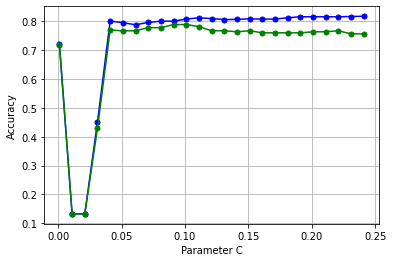

In [40]:
train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

plt.plot(param_range, train_mean,
         marker='o', markersize=5,
         color='blue', label='Training Accuracy')
plt.plot(param_range, test_mean,
         marker='o', markersize=5,
         color='green', label='Validation Accuracy')
plt.xlabel('Parameter C')
plt.ylabel('Accuracy')
plt.grid()
plt.show()


## Analysis

I am starting to learn more about validation plots to see if I can analyze the model quality a bit more effectively.   This is in the early stages.
The SVC model showed that these were probably the most reasonable scores (cross validation scores):  
    Mean f1: 0.457  
    Mean recall: 0.571  
    Mean precision: 0.395  
    Mean ROC AUC: 0.777  